# Разработка сверточной нейронной сети с использованием библиотеки PyTorch

## 1. Загрузка данных

### Импорт необходимых библиотек

In [ ]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot
from random import randint
import time

### Обработка данных

1. Загружаем CIFAR-10 датасет, который содержит изображения разных классов.
Нормализуем изображения путем деления всех пиксельных значений (в диапазоне [0, 255]) на 255, чтобы получить значения в диапазоне [0, 1].
2. Вычисляем средние и стандартные отклонения для каждого цветового канала (красный, зеленый, синий) изображений в датасете CIFAR-10.
3. Выводим средние и стандартные значения для каждого цветового канала.

Эти средние и стандартные значения используются для нормализации изображений в процессе обучения нейронных сетей. Нормализация входных данных помогает ускорить обучение и улучшить качество модели.

In [ ]:
cifar_trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                              download=True)
data = cifar_trainset.data / 255
mean = data.mean(axis = (0, 1, 2))
std = data.std(axis = (0, 1, 2))
print(f"Mean: {mean}   STD: {std}")

100%|██████████| 170498071/170498071 [00:02<00:00, 62382305.22it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Mean: [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

train_dataset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                             download=False,
                                             transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True)

1. Определяем последовательное преобразование (`transform_train`) для обучающего набора данных:
   - `RandomCrop(32, padding=4, padding_mode='reflect')`: Случайное обрезание изображения до размера 32x32 пикселя, причем с добавлением отраженных (reflect) пикселей на границе.
   - `RandomHorizontalFlip()`: Случайное горизонтальное отражение изображения (переворот по горизонтали).
   - `ToTensor()`: Преобразование изображения в тензор.
   - `Normalize(mean, std)`: Нормализация изображения с использованием ранее вычисленных средних (`mean`) и стандартных (`std`) значений.

2. Создаем обучающий датасет (`train_dataset`) из CIFAR-10 данных с указанными настройками:
   - `root='./dataset'`: Указываем путь к корневой папке, где хранится датасет (или где он будет загружен, если не существует).
   - `train=True`: Указываем, что используется обучающая выборка.
   - `download=False`: Загрузка датасета не требуется, так как он уже должен быть загружен или находиться в указанной папке.
   - `transform=transform_train`: Применяем определенное преобразование (`transform_train`) к изображениям при загрузке.

3. Создаем загрузчик данных (`train_loader`), который позволяет итерироваться по данным в мини-пакетах (`batch_size`) и перемешивать их (`shuffle=True`) на каждой эпохе обучения. `BATCH_SIZE` - количество образцов в одном мини-пакете для обучения модели.


In [ ]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

test_dataset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                            download=False,
                                            transform=transform_test)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=256, shuffle=False)

In [ ]:
CLASSES = train_dataset.classes

Провизаулизируем изображения в тестовой и обучающей выборке

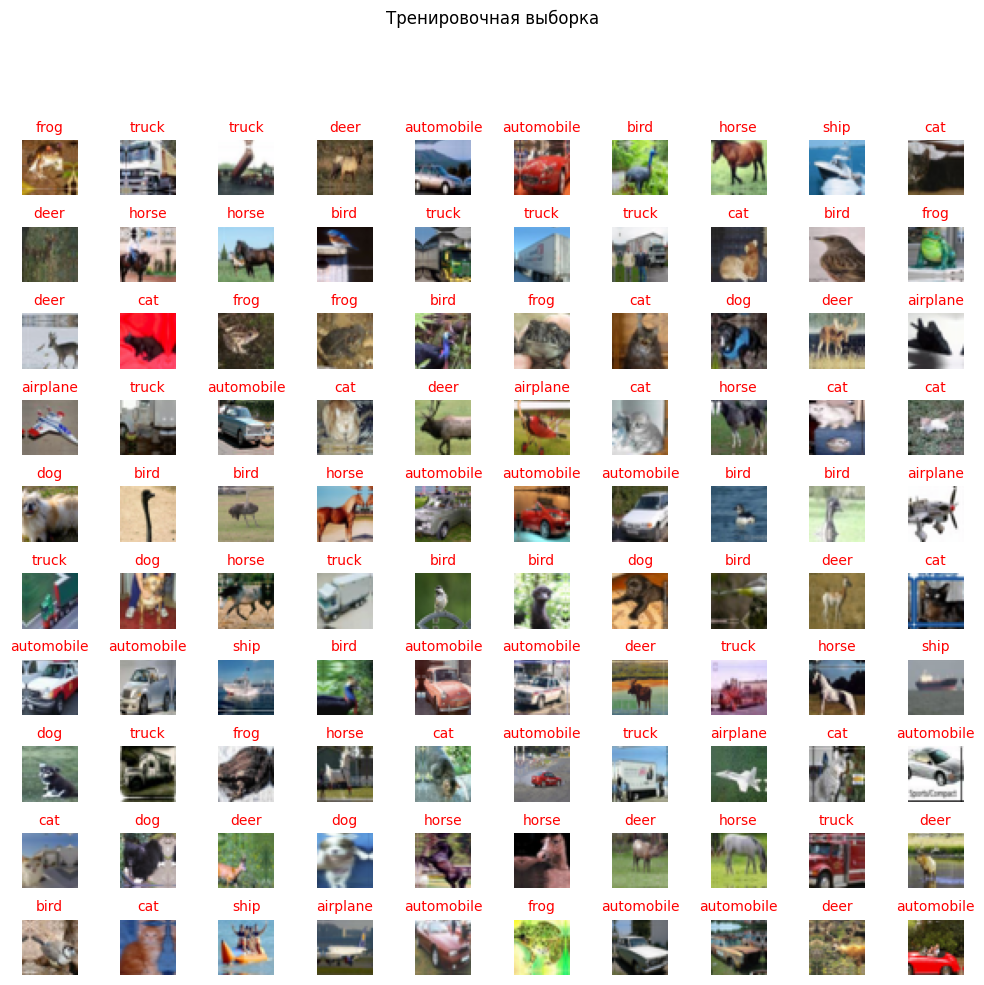

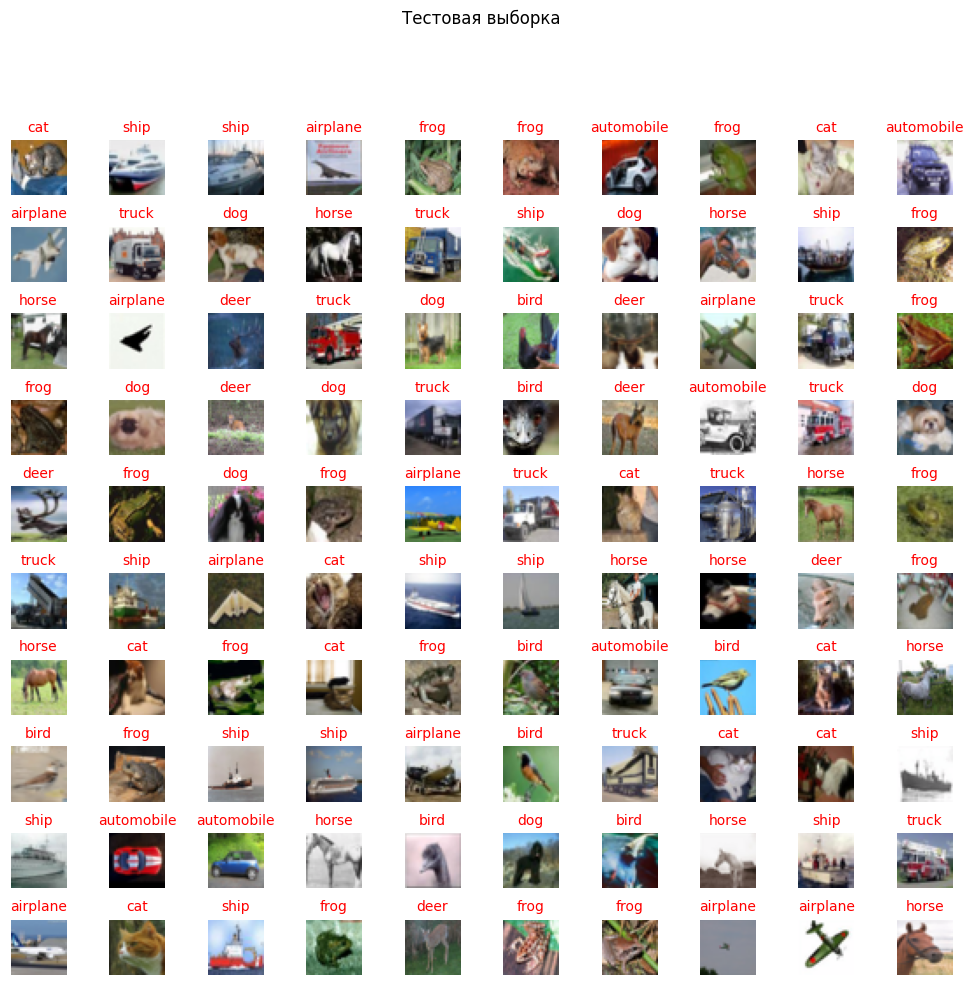

In [ ]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y,
                              num_showed_imgs_x, figsize=figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        original_img = (images[i][0] * torch.tensor(std).reshape(3, 1, 1) +
                        torch.tensor(mean).reshape(3, 1, 1))
        img = original_img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        ax.set_title(str(CLASSES[images[i][1]]), color='red', fontsize=10)
        ax.axis('off')

    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plot.tight_layout()
    plot.subplots_adjust(top=0.85)

show_images(train_dataset, 'Тренировочная выборка')
show_images(test_dataset, 'Тестовая выборка')

In [ ]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def view_image(image, title):
    img = denormal(image[0], *(mean, std))
    img = img.numpy().transpose(1, 2, 0)
    figsize = (10, 10)
    plot.title(f"{title}: {CLASSES[image[1]]}")
    plot.imshow((img * 255).astype('uint8'))

Label: 9


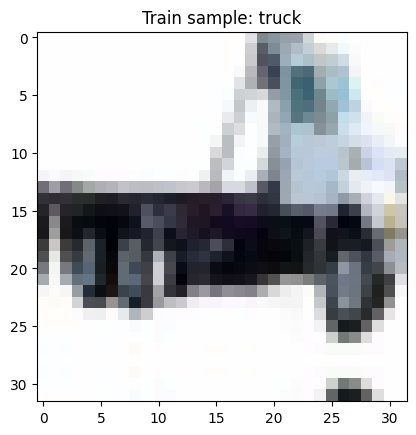

In [ ]:
index = randint(1, 5000)
view_image(train_dataset[index], 'Train sample')
print(f'Label: {train_dataset[index][1]}')

In [ ]:
print(f'Объем тренировочной выборки: {train_dataset.data.shape[0]}')
print(f'Объем тестовой выборки: {test_dataset.data.shape[0]}')

print(f'Размерность тренировочной выборки: {train_dataset.data.shape[1:]}')
print(f'Размерность тестовой выборки: {test_dataset.data.shape[1:]}')

Объем тренировочной выборки: 50000
Объем тестовой выборки: 10000
Размерность тренировочной выборки: (32, 32, 3)
Размерность тестовой выборки: (32, 32, 3)


## 2. Построение архитектуры сверточной сети

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

class ResNet10(torch.nn.Module):
    def __init__(self):
        super(ResNet10, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=3, padding=1), torch.nn.BatchNorm2d(64), torch.nn.ReLU(inplace=True))
        self.conv_and_pool_1 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.res1 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)), torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)))
        self.conv_and_pool_2 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size=3, padding=1), torch.nn.BatchNorm2d(256), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.conv_and_pool_3 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(256, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.res2 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)), torch.nn.Sequential(torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)))
        self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
        self.dense = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Dropout(0.2), torch.nn.Linear(512, 10))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv_and_pool_1(out)
        out = self.res1(out) + out
        out = self.conv_and_pool_2(out)
        out = self.conv_and_pool_3(out)
        out = self.res2(out) + out
        out = self.final_pool(out)
        out = self.dense(out)
        return out

cnn_model = ResNet10()
cnn_model

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
    start = time.time()
    for epoch in range(epochs):
        startep = time.time()
        accs = []
        lss = []
        for i, (images, labels) in enumerate(data_loader):
            labels = labels.to(device)
            images = images.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_function(outputs, labels)
            acc = accuracy(outputs, labels)
            lss.append(loss)
            accs.append(acc)
            loss.backward()
            optimizer.step()
            endep = time.time()
        loss_ = torch.stack(lss).mean()
        accuracy_ = torch.stack(accs).mean()
        time_ = endep - startep
        print(f'{epoch + 1}) loss = {loss_}, accuracy = {accuracy_}, time = {time_}')
    end = time.time()
    print(f'Общее время обучения {end - start}')

train(cnn_model, train_data_loader, 30, torch.nn.CrossEntropyLoss(), torch.optim.Adam(cnn_model.parameters(), lr = 0.001), device)

1) loss = 1.4884312152862549, accuracy = 0.4782445728778839, time = 53.26158428192139
2) loss = 0.9211729168891907, accuracy = 0.6749003529548645, time = 45.66463088989258
3) loss = 0.7211471796035767, accuracy = 0.7485252022743225, time = 45.696773052215576
4) loss = 0.6064117550849915, accuracy = 0.7896444201469421, time = 46.44551610946655
5) loss = 0.5221277475357056, accuracy = 0.8199697136878967, time = 46.56157350540161
6) loss = 0.46990910172462463, accuracy = 0.8376793265342712, time = 45.76162385940552
7) loss = 0.41181766986846924, accuracy = 0.8577806353569031, time = 46.23779225349426
8) loss = 0.3831106722354889, accuracy = 0.8678092956542969, time = 47.98403859138489
9) loss = 0.3477475643157959, accuracy = 0.8800223469734192, time = 46.14199352264404
10) loss = 0.32589566707611084, accuracy = 0.8880660533905029, time = 45.855642795562744
11) loss = 0.2929718494415283, accuracy = 0.8977758288383484, time = 45.26925039291382
12) loss = 0.2737971246242523, accuracy = 0.904

In [ ]:
loss = get_loss(cnn_model, test_data_loader, device)
accuracy = get_accuracy(cnn_model, test_data_loader, device)
print(f'Loss = {loss}, accuracy = {accuracy}')

Loss = 0.0014534073416143656, accuracy = 0.903499960899353
